# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.

In [1]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [2]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

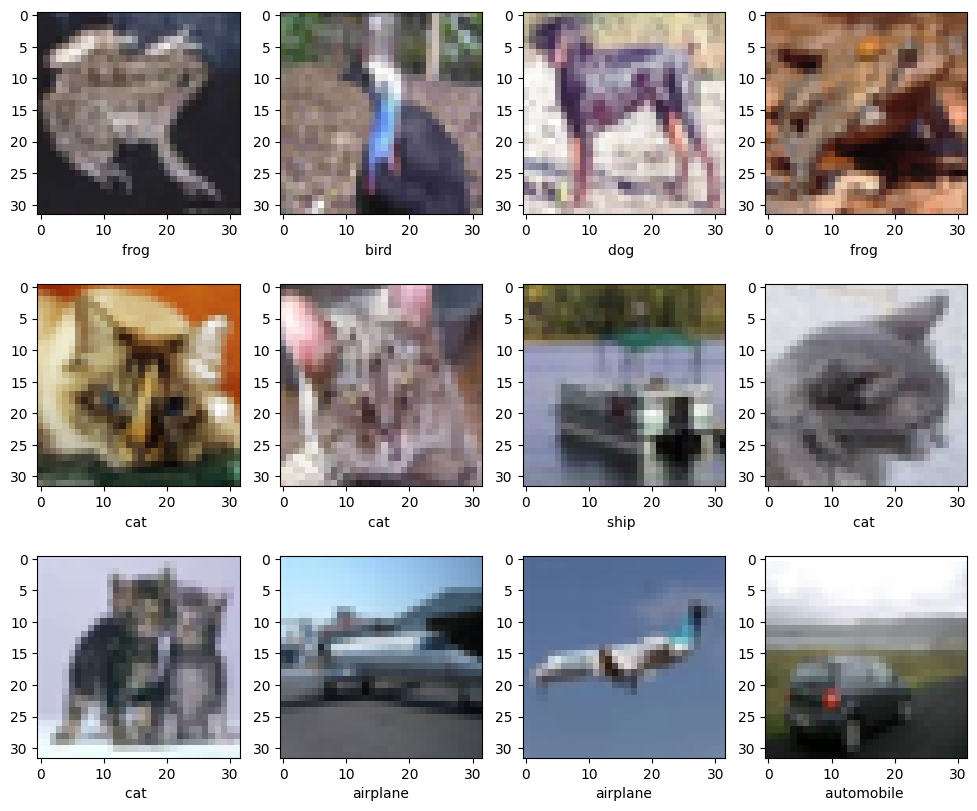

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [4]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [5]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [6]:
import keras
from keras import layers as L
from keras import backend as K

In [7]:
from keras.utils import to_categorical

y_test = to_categorical(y_test, num_classes=10)
y_train = to_categorical(y_train, num_classes=10)

In [8]:
y_train.shape

(40000, 10)

In [9]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32, 3)),  # Вытягиваем картинку в вектор
    keras.layers.Dense(128, activation='relu'), # Полносвязный слой с 128 нейронами и функцией активации ReLU
    keras.layers.Dense(10, activation='softmax')    # Выходной слой с 10 нейронами и функцией активации softmax
])

In [10]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 [==============================] - 4s 4s/step
Успех!


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394634 (1.51 MB)
Trainable params: 394634 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [12]:
# y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5),
]


In [14]:
model.compile(
    optimizer=keras.optimizers.SGD(
    momentum=0.9,
    nesterov=True),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)


In [15]:
model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=100,
    callbacks=callbacks,
    validation_data=(X_test, y_test),
)

Epoch 1/10
400/400 [==============================] - 3s 5ms/step - loss: 1.8527 - accuracy: 0.3397 - val_loss: 1.7396 - val_accuracy: 0.3831
Epoch 2/10
400/400 [==============================] - 2s 4ms/step - loss: 1.6730 - accuracy: 0.4088 - val_loss: 1.6760 - val_accuracy: 0.3923
Epoch 3/10
400/400 [==============================] - 1s 4ms/step - loss: 1.5992 - accuracy: 0.4348 - val_loss: 1.6305 - val_accuracy: 0.4165
Epoch 4/10
400/400 [==============================] - 2s 5ms/step - loss: 1.5549 - accuracy: 0.4484 - val_loss: 1.5433 - val_accuracy: 0.4476
Epoch 5/10
400/400 [==============================] - 2s 4ms/step - loss: 1.5183 - accuracy: 0.4638 - val_loss: 1.5363 - val_accuracy: 0.4518
Epoch 6/10
400/400 [==============================] - 1s 4ms/step - loss: 1.4904 - accuracy: 0.4745 - val_loss: 1.5025 - val_accuracy: 0.4655
Epoch 7/10
400/400 [==============================] - 1s 4ms/step - loss: 1.4638 - accuracy: 0.4843 - val_loss: 1.5175 - val_accuracy: 0.4618
Epoch 

In [16]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, sep='\n')

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 10)
(10000, 10)


А теперь можно проверить качество вашей сети, выполнив код ниже:

In [17]:
predict_x = model.predict(X_test)
classes_x = np.argmax(predict_x, axis=1)

# Преобразование меток y_test обратно в одномерный вектор
y_test_flat = np.argmax(y_test, axis=1)

test_acc = accuracy_score(y_test_flat, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


313/313 [==============================] - 1s 2ms/step

 Test_acc = 0.4742
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


model_cnn = Sequential()
model_cnn.add(Conv2D(10, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(100, activation='relu'))
model_cnn.add(Dense(10, activation='softmax'))

In [19]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 10)        280       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 10)        0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 2250)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               225100    
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 226390 (884.34 KB)
Trainable params: 226390 (884.34 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [20]:
model_cnn.compile(
    optimizer=keras.optimizers.SGD(
    momentum=0.9,
    nesterov=True),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [21]:
model_cnn.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=100,
    validation_data=(X_test, y_test)
)

Epoch 1/10
400/400 [==============================] - 8s 7ms/step - loss: 1.7582 - accuracy: 0.3698 - val_loss: 1.5661 - val_accuracy: 0.4477
Epoch 2/10
400/400 [==============================] - 2s 5ms/step - loss: 1.3824 - accuracy: 0.5070 - val_loss: 1.3192 - val_accuracy: 0.5323
Epoch 3/10
400/400 [==============================] - 2s 4ms/step - loss: 1.2521 - accuracy: 0.5588 - val_loss: 1.2915 - val_accuracy: 0.5467
Epoch 4/10
400/400 [==============================] - 2s 4ms/step - loss: 1.1647 - accuracy: 0.5896 - val_loss: 1.1911 - val_accuracy: 0.5733
Epoch 5/10
400/400 [==============================] - 2s 4ms/step - loss: 1.0939 - accuracy: 0.6146 - val_loss: 1.1698 - val_accuracy: 0.5854
Epoch 6/10
400/400 [==============================] - 2s 4ms/step - loss: 1.0326 - accuracy: 0.6346 - val_loss: 1.1552 - val_accuracy: 0.5947
Epoch 7/10
400/400 [==============================] - 2s 4ms/step - loss: 0.9712 - accuracy: 0.6591 - val_loss: 1.1577 - val_accuracy: 0.5990
Epoch 

In [22]:
predict_x = model_cnn.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

# Преобразование меток y_test обратно в одномерный вектор
y_test_flat = np.argmax(y_test, axis=1)

test_acc = accuracy_score(y_test_flat, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 1s 2ms/step

 Test_acc = 0.6035
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций.

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [13]:
from tensorflow import keras

class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            y_pred = model.predict(X_test)
            predicted_classes = np.argmax(y_pred, axis=1)
            y_test_int = np.argmax(y_test, axis=1)  # Преобразование one-hot меток в целевые классы
            accuracy = metric(y_test_int, predicted_classes)
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name, accuracy))



In [14]:
!rm -rf ./logs

In [15]:
# optimizers = {
#     # 'optimizer_name': optimizer
# }


from tensorflow.keras import optimizers
optimizers = { 'SGD': optimizers.legacy.SGD(),
               'Adam': optimizers.legacy.Adam(),
               'RMSprop': optimizers.legacy.RMSprop(),
              }


In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Создаем модель
model_comp = Sequential()
model_comp.add(Conv2D(10, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_comp.add(MaxPooling2D(pool_size=(2, 2)))
model_comp.add(Flatten())
model_comp.add(Dense(100, activation='relu'))
model_comp.add(Dense(10, activation='softmax'))

# model_adam = Sequential()
# model_adam.add(Conv2D(10, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# model_adam.add(MaxPooling2D(pool_size=(2, 2)))
# model_adam.add(Flatten())
# model_adam.add(Dense(100, activation='relu'))
# model_adam.add(Dense(10, activation='softmax'))

# model_pmsprop = Sequential()
# model_pmsprop.add(Conv2D(10, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# model_pmsprop.add(MaxPooling2D(pool_size=(2, 2)))
# model_pmsprop.add(Flatten())
# model_pmsprop.add(Dense(100, activation='relu'))
# model_pmsprop.add(Dense(10, activation='softmax'))


# # Собираем модели и оптимизаторы в словари
# models = {'model_sqd': model_sqd, 'model_adam': model_adam, 'model_pmsprop': model_pmsprop}

In [27]:
evaluator = Evaluator(model_comp, optimizers=optimizers)

In [28]:
evaluator

[('single_model',
  'SGD',
  <keras.src.optimizers.legacy.gradient_descent.SGD at 0x7a0160de9990>),
 ('single_model',
  'Adam',
  <keras.src.optimizers.legacy.adam.Adam at 0x7a0160deaec0>),
 ('single_model',
  'RMSprop',
  <keras.src.optimizers.legacy.rmsprop.RMSprop at 0x7a0160de87c0>)]

Прокомментируйте полученные результаты.

In [29]:
evaluator.fit(X_train, y_train, validation_data=(X_test, y_test), max_epochs=5)

  0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
evaluator.evaluate(X_test, y_test, accuracy_score)

313/313 [==============================] - 1s 2ms/step
Final score of single_model_SGD is 0.5222
313/313 [==============================] - 1s 2ms/step
Final score of single_model_Adam is 0.5921
313/313 [==============================] - 1s 2ms/step
Final score of single_model_RMSprop is 0.591


Как можно быть таким глупым человеком и создавать на каждый оптимизатор зачем-то свою модель, а потом именно ее использовать в evaluator, тем самым 3 модели на 3 оптимизатора = 9 обучений. Примерно час пыталась чего-то добиться, а потом поняла в чем ошибка. <b> Еще не понимаю как использовать evaluate и получить точность не делая преобразование one-hot меток в целевые классы... </b>   

SGD - 0.5222  
Adam - 0.5921     
RMSprop - 0.5910   

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [17]:
from collections import OrderedDict
from keras.layers import BatchNormalization

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)

    def add(self, layer):
        for name, model in self.items():
            model.add(layer)

    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

In [19]:
!rm -rf ./logs

In [19]:
full_norm = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32, 3)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),  # Add BatchNormalization layer here
    keras.layers.Dense(10, activation='softmax')
])

In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation

cnn_norm = Sequential()
cnn_norm.add(Conv2D(10, (3, 3), input_shape=(32, 32, 3), activation='relu'))
cnn_norm.add(MaxPooling2D(pool_size=(2, 2)))
cnn_norm.add(Flatten())
cnn_norm.add(Dense(100))
cnn_norm.add(BatchNormalization())  # Add BatchNormalization
cnn_norm.add(Activation('relu'))  # Add ReLU activation after BatchNormalization
cnn_norm.add(Dense(10, activation='softmax'))


In [21]:
models = Models({'full_with_norm': full_norm, 'cnn_with_norm': cnn_norm})

In [22]:
# Display the model summary for the base model
print("full_with_norm")
models['full_with_norm'].summary()

# Display the model summary for the model with BatchNormalization layer
print("\ncnn_with_norm:")
models['cnn_with_norm'].summary()

full_with_norm
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 3072)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               393344    
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 10)                1290      
                                                                 
Total params: 395146 (1.51 MB)
Trainable params: 394890 (1.51 MB)
Non-trainable params: 256 (1.00 KB)
_________________________________________________________________

cnn_with_norm:
Model: "sequential_5"
_______________________________

In [38]:
evaluator = Evaluator(models, optimizers=optimizers)

In [39]:
evaluator

[('full_with_norm',
  'SGD',
  <keras.src.optimizers.legacy.gradient_descent.SGD at 0x7a0160de9990>),
 ('full_with_norm',
  'Adam',
  <keras.src.optimizers.legacy.adam.Adam at 0x7a0160deaec0>),
 ('full_with_norm',
  'RMSprop',
  <keras.src.optimizers.legacy.rmsprop.RMSprop at 0x7a0160de87c0>),
 ('cnn_with_norm',
  'SGD',
  <keras.src.optimizers.legacy.gradient_descent.SGD at 0x7a0160de9990>),
 ('cnn_with_norm',
  'Adam',
  <keras.src.optimizers.legacy.adam.Adam at 0x7a0160deaec0>),
 ('cnn_with_norm',
  'RMSprop',
  <keras.src.optimizers.legacy.rmsprop.RMSprop at 0x7a0160de87c0>)]

In [40]:
evaluator.fit(X_train, y_train, validation_data=(X_test, y_test), max_epochs=5)

  0%|          | 0/6 [00:00<?, ?it/s]

In [41]:
evaluator.evaluate(X_test, y_test, accuracy_score)

313/313 [==============================] - 1s 2ms/step
Final score of full_with_norm_SGD is 0.4097
313/313 [==============================] - 1s 2ms/step
Final score of full_with_norm_Adam is 0.3797
313/313 [==============================] - 1s 2ms/step
Final score of full_with_norm_RMSprop is 0.4195
313/313 [==============================] - 1s 2ms/step
Final score of cnn_with_norm_SGD is 0.5592
313/313 [==============================] - 1s 2ms/step
Final score of cnn_with_norm_Adam is 0.6012
313/313 [==============================] - 1s 2ms/step
Final score of cnn_with_norm_RMSprop is 0.599


In [25]:
evaluator = Evaluator(model, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_test, y_test), max_epochs=5)
evaluator.evaluate(X_test, y_test, accuracy_score)

  0%|          | 0/3 [00:00<?, ?it/s]

313/313 [==============================] - 1s 3ms/step
Final score of single_model_SGD is 0.436
313/313 [==============================] - 1s 2ms/step
Final score of single_model_Adam is 0.3924
313/313 [==============================] - 1s 2ms/step
Final score of single_model_RMSprop is 0.3989


In [26]:
evaluator = Evaluator(model_cnn, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_test, y_test), max_epochs=5)
evaluator.evaluate(X_test, y_test, accuracy_score)

  0%|          | 0/3 [00:00<?, ?it/s]

313/313 [==============================] - 1s 3ms/step
Final score of single_model_SGD is 0.5331
313/313 [==============================] - 1s 2ms/step
Final score of single_model_Adam is 0.579
313/313 [==============================] - 1s 3ms/step
Final score of single_model_RMSprop is 0.561


Прокомментируйте полученные результаты.

| Модель             | SGD    | Adam   | RMSprop |
|--------------------|--------|--------|---------|
| Полносвязная (norm)      | 0.4097 | 0.3797 | 0.4195  |
| Полносвязная      | 0.4360 | 0.3924 | 0.3989  |
| Сверточная (norm)       | 0.5592 | 0.6012 | 0.5990  |
| Сверточная        | 0.5331 | 0.5790 | 0.5610  |

Таким образом, мы видим, что результаты слишком незначительны, чтобы добавлять один слой batch normalization   

**Надеюсь, что это нормально...**

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

In [23]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)

In [24]:
evaluator = Evaluator(models, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_test, y_test), max_epochs=100, callbacks=[early_stopping])

  0%|          | 0/6 [00:00<?, ?it/s]

In [25]:
evaluator.evaluate(X_test, y_test, accuracy_score)

313/313 [==============================] - 1s 2ms/step
Final score of full_with_norm_SGD is 0.4473
313/313 [==============================] - 1s 2ms/step
Final score of full_with_norm_Adam is 0.4475
313/313 [==============================] - 1s 2ms/step
Final score of full_with_norm_RMSprop is 0.4115
313/313 [==============================] - 1s 2ms/step
Final score of cnn_with_norm_SGD is 0.6133
313/313 [==============================] - 1s 2ms/step
Final score of cnn_with_norm_Adam is 0.624
313/313 [==============================] - 1s 2ms/step
Final score of cnn_with_norm_RMSprop is 0.6134


| Модель             | SGD    | Adam   | RMSprop |
|--------------------|--------|--------|---------|
| Полносвязная (norm)      | 0.4097 | 0.3797 | 0.4195  |
| Полносвязная (stop) !      | 0.4473 | 0.4475 | 0.4115  |
| Полносвязная      | 0.4360 | 0.3924 | 0.3989  |
| Сверточная (norm)       | 0.5592 | 0.6012 | 0.5990  |
| Сверточная (stop) !      | 0.6133 | 0.6240 | 0.6134  |
| Сверточная        | 0.5331 | 0.5790 | 0.5610  |

Как можно заметить, результаты улучшились!

`monitor` - это метрика, которую мы отслеживаем (в данном случае, точность на валидационном наборе)   
 `patience` - количество эпох без улучшений, после которого обучение будет прекращено   
  `restore_best_weights=True` позволяет восстановить веса модели до наилучшей эпохи

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

In [26]:
def plot_training_history(history, optimizer, normalization):

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Time')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Time')
    plt.legend()
    plt.grid(True)

    plt.suptitle(f'Optimizer: {optimizer}, Normalization: {normalizations[1].name if normalization else normalization}', fontsize=14)

    plt.show()


Epoch 1/10
1250/1250 [==============================] - 9s 6ms/step - loss: 1.9221 - accuracy: 0.3102 - val_loss: 1.7796 - val_accuracy: 0.3749
Epoch 2/10
1250/1250 [==============================] - 9s 7ms/step - loss: 1.7454 - accuracy: 0.3821 - val_loss: 1.7097 - val_accuracy: 0.3896
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.6675 - accuracy: 0.4137 - val_loss: 1.6468 - val_accuracy: 0.4181
Epoch 4/10
1250/1250 [==============================] - 8s 6ms/step - loss: 1.6175 - accuracy: 0.4310 - val_loss: 1.6238 - val_accuracy: 0.4222
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.5820 - accuracy: 0.4442 - val_loss: 1.5982 - val_accuracy: 0.4415
Epoch 6/10
1250/1250 [==============================] - 7s 5ms/step - loss: 1.5531 - accuracy: 0.4524 - val_loss: 1.5611 - val_accuracy: 0.4473
Epoch 7/10
1250/1250 [==============================] - 7s 6ms/step - loss: 1.5282 - accuracy: 0.4660 - val_loss: 1.5345 - val_accuracy:

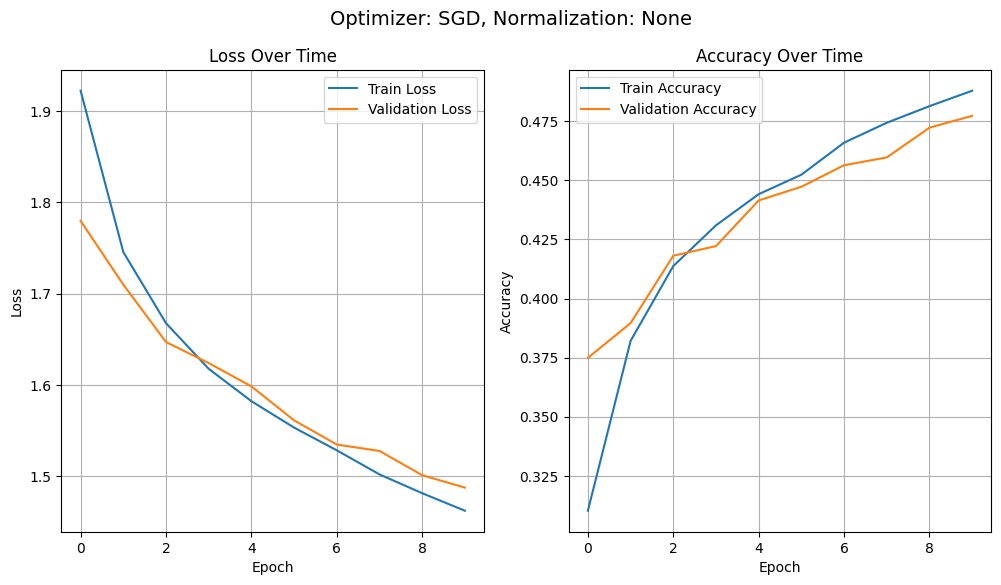

Optimizer: SGD, Normalization: None, Validation Accuracy: 0.4772999882698059
Epoch 1/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8518 - accuracy: 0.3501 - val_loss: 1.7585 - val_accuracy: 0.3808
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7311 - accuracy: 0.3975 - val_loss: 1.7087 - val_accuracy: 0.3986
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6786 - accuracy: 0.4151 - val_loss: 1.7114 - val_accuracy: 0.3966
Epoch 4/10
1250/1250 [==============================] - 6s 4ms/step - loss: 1.6403 - accuracy: 0.4290 - val_loss: 1.6556 - val_accuracy: 0.4139
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6123 - accuracy: 0.4361 - val_loss: 1.6278 - val_accuracy: 0.4214
Epoch 6/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.5963 - accuracy: 0.4422 - val_loss: 1.6570 - val_accuracy: 0.4115
Epoch 7/10
1250/1250 [==============================] - 5s 

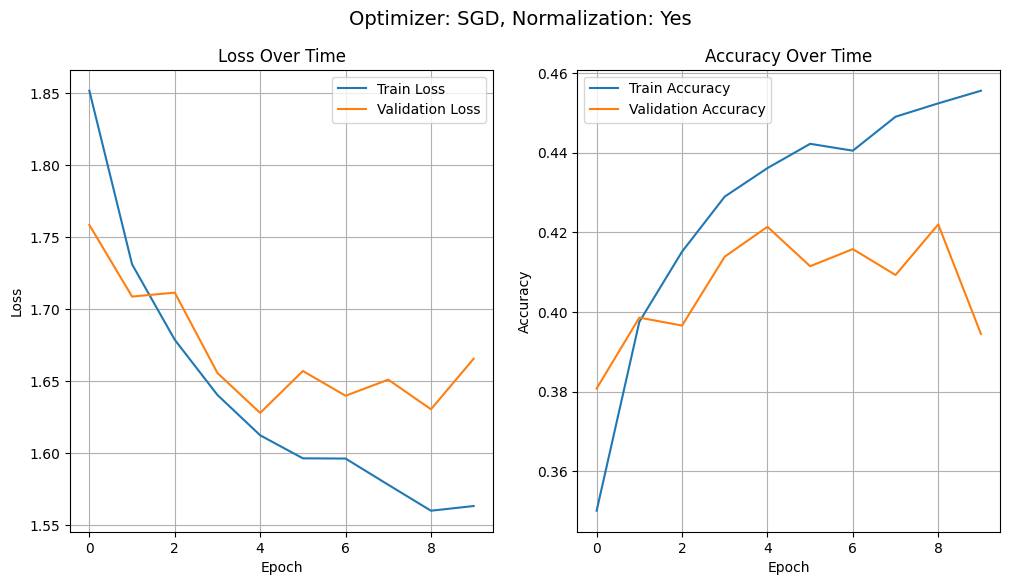

Optimizer: SGD, Normalization: Yes, Validation Accuracy: 0.3944999873638153
Epoch 1/10
1250/1250 [==============================] - 6s 4ms/step - loss: 1.9138 - accuracy: 0.3104 - val_loss: 1.8666 - val_accuracy: 0.3392
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.7746 - accuracy: 0.3636 - val_loss: 1.7203 - val_accuracy: 0.3883
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.7194 - accuracy: 0.3873 - val_loss: 1.6946 - val_accuracy: 0.3949
Epoch 4/10
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6971 - accuracy: 0.3941 - val_loss: 1.7058 - val_accuracy: 0.3879
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6757 - accuracy: 0.4049 - val_loss: 1.6523 - val_accuracy: 0.4100
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6588 - accuracy: 0.4087 - val_loss: 1.6615 - val_accuracy: 0.4085
Epoch 7/10
1250/1250 [==============================] - 4s 3

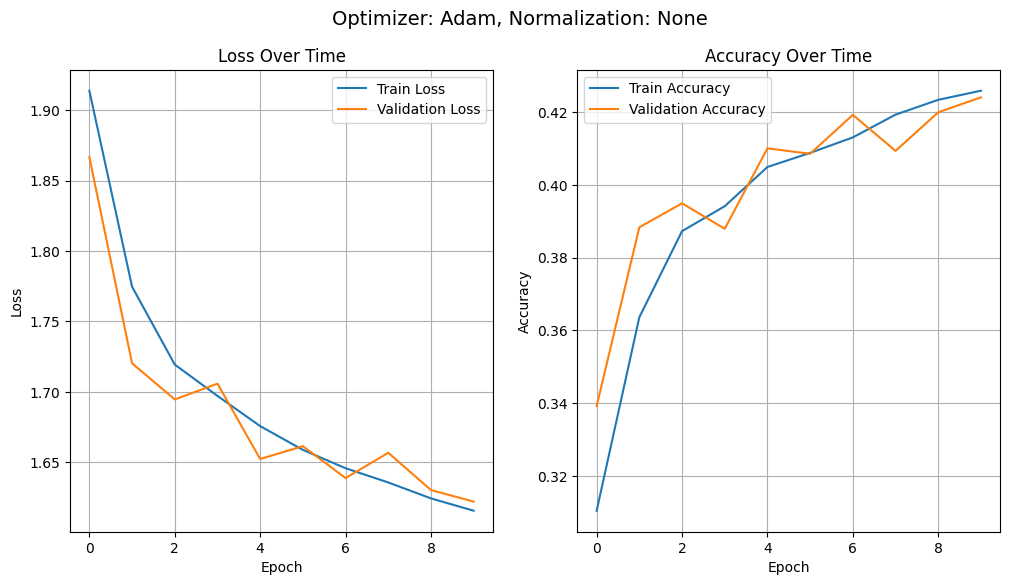

Optimizer: Adam, Normalization: None, Validation Accuracy: 0.42399999499320984
Epoch 1/10
1250/1250 [==============================] - 7s 5ms/step - loss: 1.8342 - accuracy: 0.3621 - val_loss: 1.7919 - val_accuracy: 0.3581
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7315 - accuracy: 0.3972 - val_loss: 1.8816 - val_accuracy: 0.3607
Epoch 3/10
1250/1250 [==============================] - 6s 4ms/step - loss: 1.6899 - accuracy: 0.4136 - val_loss: 1.6953 - val_accuracy: 0.3983
Epoch 4/10
1250/1250 [==============================] - 6s 4ms/step - loss: 1.6746 - accuracy: 0.4187 - val_loss: 1.7366 - val_accuracy: 0.3685
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.6577 - accuracy: 0.4232 - val_loss: 1.7588 - val_accuracy: 0.3902
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6196 - accuracy: 0.4355 - val_loss: 1.7059 - val_accuracy: 0.4059
Epoch 7/10
1250/1250 [==============================] - 6

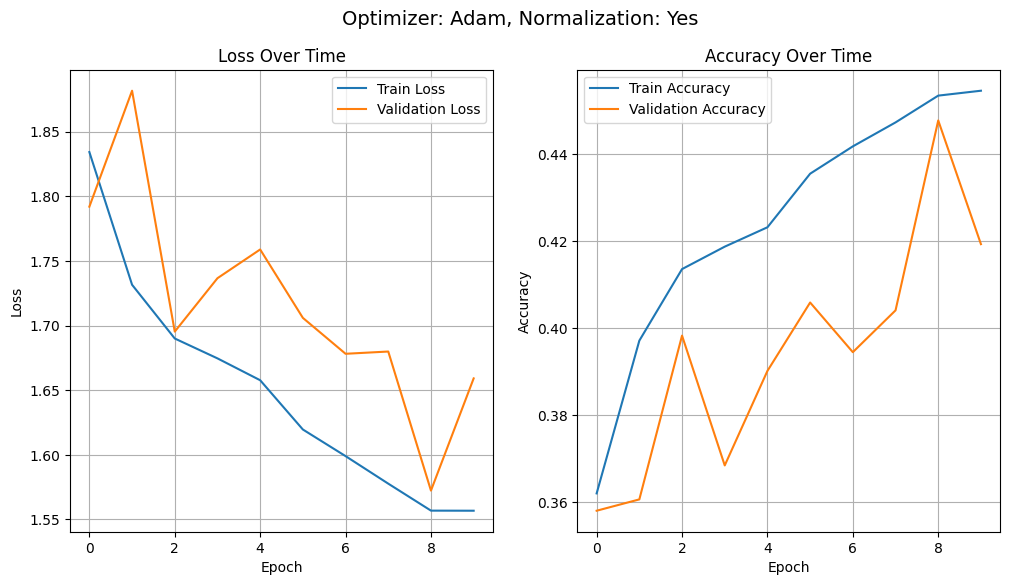

Optimizer: Adam, Normalization: Yes, Validation Accuracy: 0.41929998993873596
Epoch 1/10
1250/1250 [==============================] - 6s 4ms/step - loss: 1.9932 - accuracy: 0.2871 - val_loss: 1.8254 - val_accuracy: 0.3390
Epoch 2/10
1250/1250 [==============================] - 4s 4ms/step - loss: 1.7866 - accuracy: 0.3609 - val_loss: 1.7543 - val_accuracy: 0.3700
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7289 - accuracy: 0.3857 - val_loss: 1.7155 - val_accuracy: 0.3818
Epoch 4/10
1250/1250 [==============================] - 4s 4ms/step - loss: 1.6940 - accuracy: 0.3967 - val_loss: 1.7251 - val_accuracy: 0.3829
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6681 - accuracy: 0.4060 - val_loss: 1.6692 - val_accuracy: 0.4080
Epoch 6/10
1250/1250 [==============================] - 4s 4ms/step - loss: 1.6400 - accuracy: 0.4145 - val_loss: 1.6367 - val_accuracy: 0.4129
Epoch 7/10
1250/1250 [==============================] - 4s

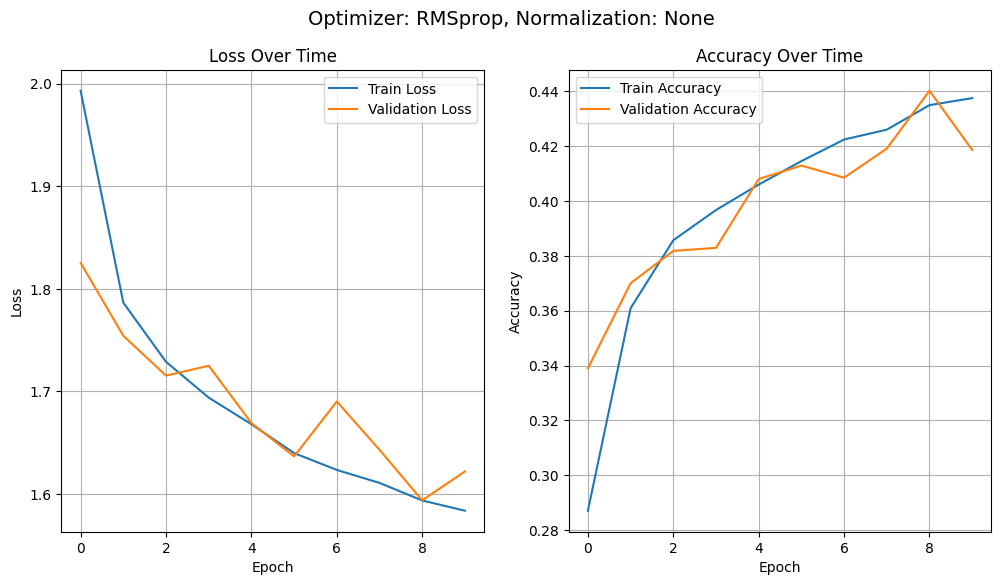

Optimizer: RMSprop, Normalization: None, Validation Accuracy: 0.4185999929904938
Epoch 1/10
1250/1250 [==============================] - 6s 4ms/step - loss: 1.8335 - accuracy: 0.3581 - val_loss: 1.8189 - val_accuracy: 0.3569
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7319 - accuracy: 0.3975 - val_loss: 1.7708 - val_accuracy: 0.3804
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.7071 - accuracy: 0.4017 - val_loss: 1.7519 - val_accuracy: 0.3733
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6775 - accuracy: 0.4111 - val_loss: 1.7291 - val_accuracy: 0.3885
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6575 - accuracy: 0.4175 - val_loss: 1.8080 - val_accuracy: 0.3495
Epoch 6/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.6381 - accuracy: 0.4259 - val_loss: 1.7943 - val_accuracy: 0.3722
Epoch 7/10
1250/1250 [==============================] -

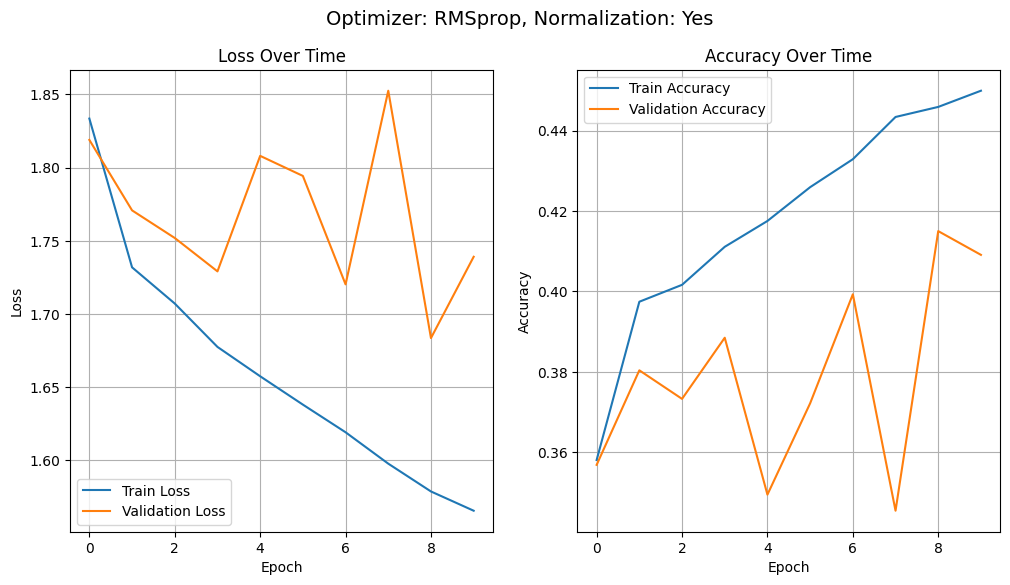

Optimizer: RMSprop, Normalization: Yes, Validation Accuracy: 0.4090999960899353
Best combination: Optimizer: SGD, Normalization: None, Best Validation Accuracy: 0.4772999882698059


In [27]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

normalizations = [None, BatchNormalization(name='Yes')]

batch_size = 32
epochs = 10

def find_best_combination(optimizer, normalization):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(32 * 32 * 3,)))

    if normalization:
        model.add(normalization)

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

    return history

best_accuracy = 0.0
best_combination = None

for optimizer in optimizers:
    for normalization in normalizations:
        history = find_best_combination(optimizer, normalization)
        plot_training_history(history, optimizer, normalization)

        val_accuracy = history.history['val_accuracy'][-1]
        print(f"Optimizer: {optimizer}, Normalization: {normalizations[1].name if normalization else normalization}, Validation Accuracy: {val_accuracy}")

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_combination = (optimizer, normalization)

print(f"Best combination: Optimizer: {best_combination[0]}, Normalization: {best_combination[1]}, Best Validation Accuracy: {best_accuracy}")


In [28]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [29]:
print(f"Best combination: Optimizer: {best_combination[0]}, Normalization: {best_combination[1]}, Best Validation Accuracy: {best_accuracy}")

Best combination: Optimizer: SGD, Normalization: None, Best Validation Accuracy: 0.4772999882698059


## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [31]:
import numpy as np
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout,Input, AveragePooling2D, Activation,Conv2D, MaxPooling2D, BatchNormalization,Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers, optimizers
from sklearn.model_selection import train_test_split
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=10000, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (x_train.shape,y_train.shape)

(40000, 32, 32, 3) (40000, 1)


In [32]:
x_train=x_train/255
x_test=x_test/255
y_train_cat=to_categorical(y_train,10)
y_test_cat=to_categorical(y_test,10)

In [33]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [35]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_3 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_4 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                     

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
history = model.fit(x_train, y_train_cat, epochs=10, validation_data=(x_test,y_test_cat))

Epoch 1/10
1250/1250 [==============================] - 13s 10ms/step - loss: 0.8696 - accuracy: 0.6974 - val_loss: 0.7772 - val_accuracy: 0.7354
Epoch 2/10
1250/1250 [==============================] - 13s 11ms/step - loss: 0.7912 - accuracy: 0.7268 - val_loss: 0.8707 - val_accuracy: 0.7054
Epoch 3/10
1250/1250 [==============================] - 14s 11ms/step - loss: 0.7101 - accuracy: 0.7546 - val_loss: 0.6988 - val_accuracy: 0.7613
Epoch 4/10
1250/1250 [==============================] - 13s 10ms/step - loss: 0.6732 - accuracy: 0.7711 - val_loss: 0.6380 - val_accuracy: 0.7816
Epoch 5/10
1250/1250 [==============================] - 12s 10ms/step - loss: 0.6203 - accuracy: 0.7890 - val_loss: 0.6791 - val_accuracy: 0.7676
Epoch 6/10
1250/1250 [==============================] - 15s 12ms/step - loss: 0.5865 - accuracy: 0.7999 - val_loss: 0.5903 - val_accuracy: 0.8007
Epoch 7/10
1250/1250 [==============================] - 15s 12ms/step - loss: 0.5566 - accuracy: 0.8103 - val_loss: 0.5785 -

In [42]:
evaluation = model.evaluate(x_test, y_test_cat)
print('Test Accuracy: {}'.format(evaluation[1]))

313/313 [==============================] - 1s 4ms/step - loss: 0.5162 - accuracy: 0.8261
Test Accuracy: 0.8260999917984009


<Axes: >

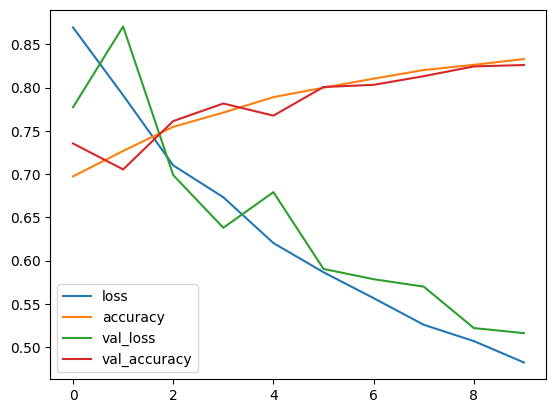

In [43]:
import pandas as pd
pd.DataFrame(history.history).plot()

Момент истины: проверьте, какого качества достигла ваша сеть.

In [44]:
from sklearn.metrics import accuracy_score

predict_x=model.predict(x_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 1s 4ms/step

 Test_acc = 0.8261
Это победа!


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов.

Интересно, но долго не могла понять ошибку в оптимизаторах. В итоге оказалось, что в `evaluation` предыдущая версия `tf` кода и надо прописывать `legacy` везде при инициализации.     
Добились всех нужных показателей, которые были заданы по условию с:
